# Bagging and Bootstrapping Regression

Purpose: Develop models to predict salary from dataset.

Author: Jordan A. Caraballo-Vega

Version: 2024.04.03

In [28]:
import random
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Load Dataset

In [3]:
salary_df = pd.read_csv('drive/MyDrive/Terminal34/ds_salaries.csv')
salary_df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [4]:
salary_df.describe(include=object)

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,3755,3755,3755,3755,3755,3755,3755
unique,4,4,93,20,78,72,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,2516,3718,1040,3224,3004,3040,3153


In [18]:
salary_df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

## 3. Perform EDA

<Axes: xlabel='experience_level', ylabel='count'>

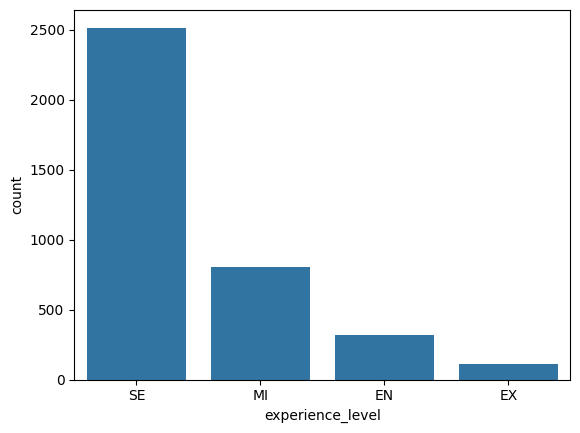

In [5]:
sns.countplot(data=salary_df, x='experience_level')

<Axes: xlabel='employment_type', ylabel='count'>

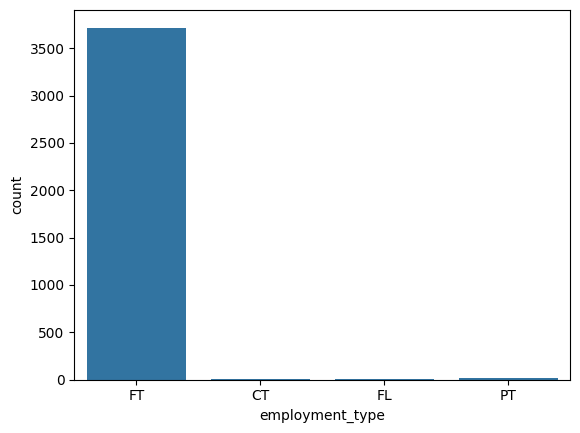

In [6]:
sns.countplot(data=salary_df, x='employment_type')

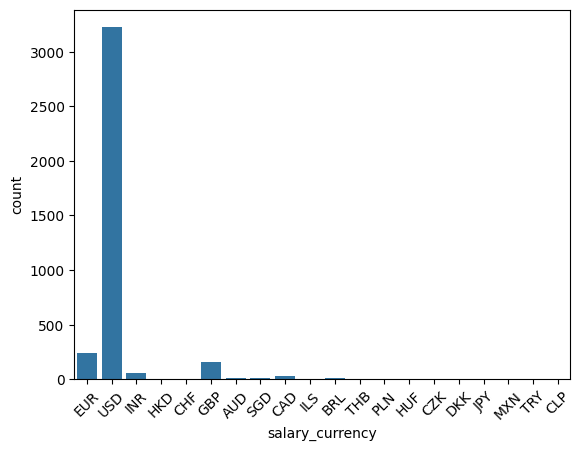

In [8]:
sns.countplot(data=salary_df, x='salary_currency')
plt.xticks(rotation=45)
plt.show()

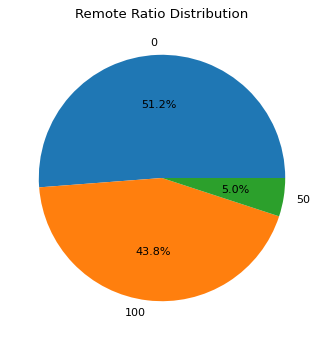

In [11]:
plt.figure(figsize=(6,5),dpi=80)
level_counts = salary_df['remote_ratio'].value_counts()
plt.pie(level_counts.values, labels=level_counts.index, autopct='%1.1f%%')
plt.title('Remote Ratio Distribution')
plt.show()

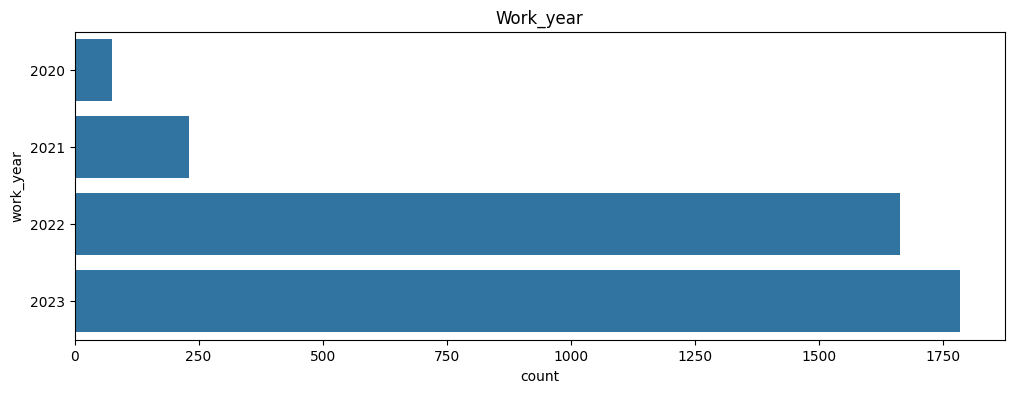

In [15]:
plt.figure(figsize=[12,4])
sns.countplot(y=salary_df['work_year'])
plt.title('Work_year')
plt.show()

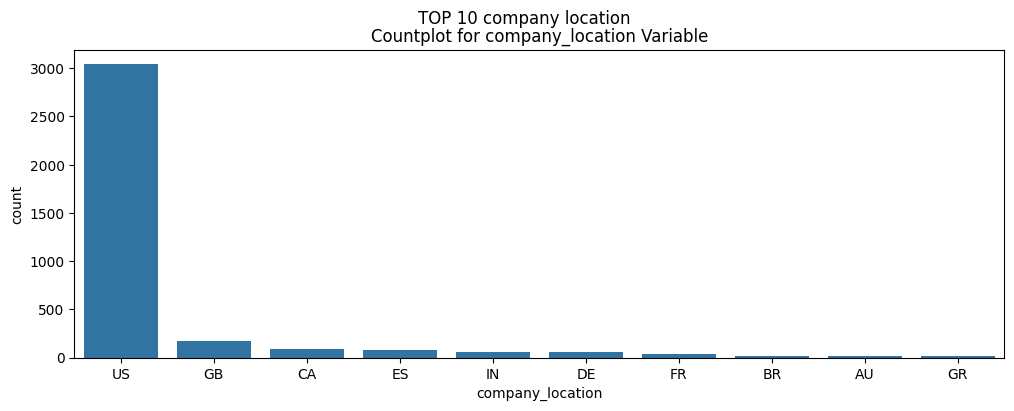

In [16]:
plt.figure(figsize=[12,4])
sns.countplot(
    x=salary_df['company_location'],
    order=salary_df['company_location'].value_counts().iloc[:10].index)
plt.title('Countplot for company_location Variable')
plt.suptitle("TOP 10 company location")
plt.show()

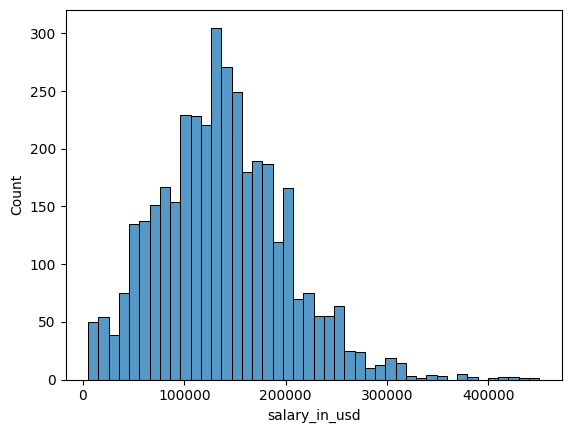

In [17]:
sns.histplot(data=salary_df, x='salary_in_usd')
plt.show()

## 4. Perform Feature Engineering

In [19]:
salary_df_fixed = salary_df.drop(['salary', 'salary_currency'], axis=1)
salary_df_fixed.head(10)

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,CA,100,CA,M
5,2023,SE,FT,Applied Scientist,222200,US,0,US,L
6,2023,SE,FT,Applied Scientist,136000,US,0,US,L
7,2023,SE,FT,Data Scientist,219000,CA,0,CA,M
8,2023,SE,FT,Data Scientist,141000,CA,0,CA,M
9,2023,SE,FT,Data Scientist,147100,US,0,US,M


In [20]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [21]:
columns_to_encoder = [
    'employment_type', 'job_title', 'employee_residence',
    'company_location','experience_level','company_size'
]
salary_df_fixed[columns_to_encoder] = salary_df_fixed[columns_to_encoder].apply(
    label_encoder.fit_transform)
salary_df_fixed.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,3,2,84,85847,26,100,25,0
1,2023,2,0,66,30000,75,100,70,2
2,2023,2,0,66,25500,75,100,70,2
3,2023,3,2,47,175000,11,100,12,1
4,2023,3,2,47,120000,11,100,12,1


In [22]:
salary_df_fixed.describe()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000
mean,2022.373635,2.469241,1.996538,39.661784,137570.389880,66.149401,46.271638,62.117177,0.918509
std,0.691448,0.906261,0.133550,18.536695,63055.625278,19.235212,48.589050,17.495432,0.392071
min,2020.000000,0.000000,0.000000,0.000000,5132.000000,0.000000,0.000000,0.000000,0.000000
25%,2022.000000,2.000000,2.000000,27.000000,95000.000000,75.000000,0.000000,70.000000,1.000000
50%,2022.000000,3.000000,2.000000,33.000000,135000.000000,75.000000,0.000000,70.000000,1.000000
75%,2023.000000,3.000000,2.000000,47.000000,175000.000000,75.000000,100.000000,70.000000,1.000000
max,2023.000000,3.000000,3.000000,92.000000,450000.000000,77.000000,100.000000,71.000000,2.000000


In [23]:
salary_df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [24]:
X = salary_df_fixed.drop(['salary_in_usd'], axis=1)
y = salary_df_fixed['salary_in_usd']
X.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size'],
      dtype='object')

## 5. Split dataset

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.10, random_state=42)
X_train.shape, X_test.shape

((3379, 8), (376, 8))

## 6. Initialize and Train Two Ensemble Regression Models

In [26]:
def train_and_predict(X, y, model_type):

  # split training dataset
  print("Starting split dataset")
  X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

  # train model
  print("Starting to train the model")
  model = model_type
  model.fit(X_train, y_train)

  # evaluate model
  print("Starting to predict")
  y_pred = model.predict(X_test)

  # get metrics
  print("Starting to evaluate")
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  print(f"MAE: {mae:.2f}")
  print(f"MSE: {mse:.2f}")
  print(f"RMSE: {rmse:.2f}")

  # plot scatter
  print("Starting to plot")
  plt.scatter(y_test, y_pred)
  plt.xlabel('y_test')
  plt.ylabel('y_pred')
  plt.show()
  return

Starting split dataset
Starting to train the model
Starting to predict
Starting to evaluate
MAE: 37062.71
MSE: 2387797511.75
RMSE: 48865.10
Starting to plot


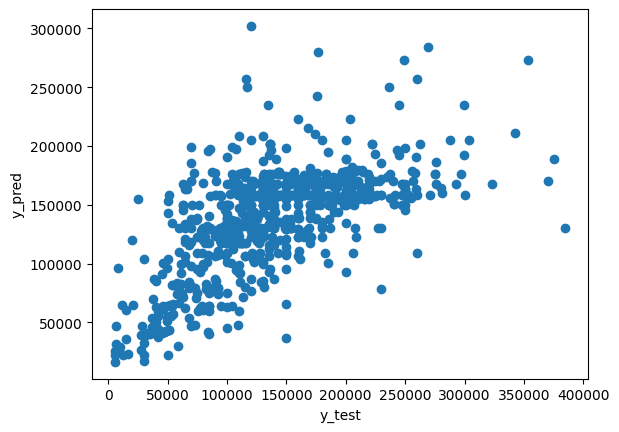

CPU times: user 4.78 s, sys: 128 ms, total: 4.9 s
Wall time: 5.14 s


In [34]:
%%time
train_and_predict(X, y, RandomForestRegressor(n_estimators=1000))

Starting split dataset
Starting to train the model
Starting to predict
Starting to evaluate
MAE: 37744.21
MSE: 2495775627.08
RMSE: 49957.74
Starting to plot


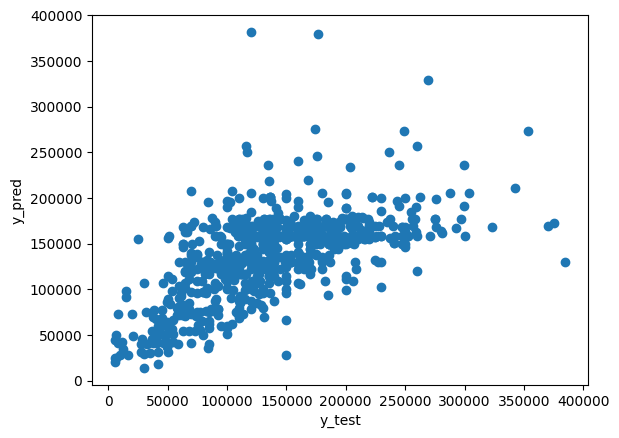

CPU times: user 4.37 s, sys: 70.4 ms, total: 4.44 s
Wall time: 4.44 s


In [35]:
%%time
train_and_predict(X, y, ExtraTreesRegressor(n_estimators=1000))

In [30]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

Starting split dataset
Starting to train the model
Starting to predict
Starting to evaluate
MAE: 36815.39
MSE: 2366126626.78
RMSE: 48642.85
Starting to plot


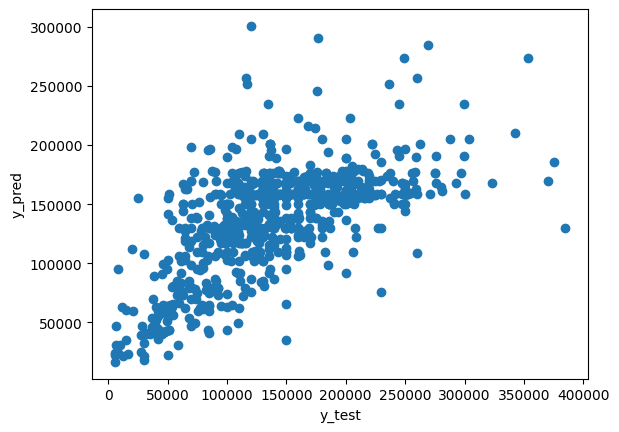

In [38]:
train_and_predict(sc.fit_transform(X), y, RandomForestRegressor(n_estimators=1000, criterion='squared_error'))